# EECS4313Z W24 Final Project Data Notebook

This notebook shows how all data for the final project were analyzed and manipulated. It shows how csv files were pre-processed and how plots were generated. Three data from all three tools is handled separately due to the slight variations in their individual schema.

### SonarCloud Data

The data is retrievable from a web api as JSON files. The files are parsed into csv as follows:

In [1]:
import json
import pandas as pd

def json_to_csv(json_path):
    
    with open(json_path) as file:
        parsed_data = json.load(file)
    
    for issue in parsed_data['issues']:
        issue['line_number'] = issue['textRange']['startLine']
        issue['file_path'] = issue.pop('component')
        issue['description'] = issue.pop('message')
        impact = issue['impacts'][0]
        issue['software_quality'] = impact['softwareQuality']
        issue['severity_impact'] = impact['severity']
        del issue['impacts']
    
    df = pd.DataFrame(parsed_data['issues'])
    df['file_path'] = df['file_path'].apply(lambda x: x.split(':')[-1])
    df.drop('severity',axis=1,inplace=True)
    df.rename(columns={'severity_impact':'severity'},inplace=True)
    
    write_path = json_path.replace('json', 'csv')
    
    df[['file_path','line_number','type','severity','description']].to_csv(write_path, index=False)

json_paths = [
    "sonarcloud_data/json/sonarcloud_ebean.json",
    "sonarcloud_data/json/sonarcloud_hibernate-orm.json",
    "sonarcloud_data/json/sonarcloud_openjpa.json",
    "sonarcloud_data/json/sonarcloud_ponyorm.json",
    "sonarcloud_data/json/sonarcloud_sqlalchemy.json"
]

for path in json_paths:
    json_to_csv(path)

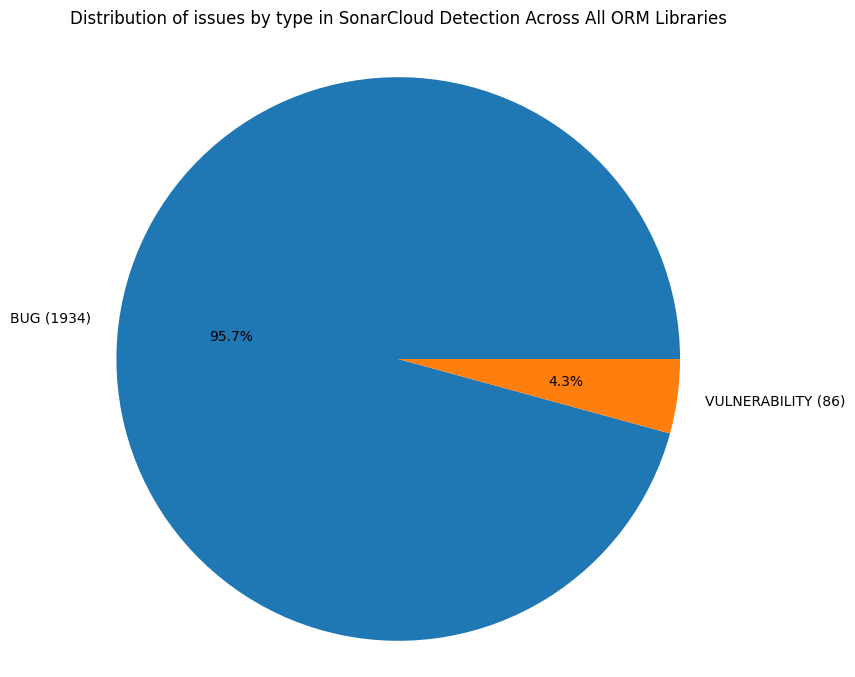

In [2]:
import matplotlib.pyplot as plt

csv_paths = [
    "sonarcloud_data/csv/sonarcloud_ebean.csv",
    "sonarcloud_data/csv/sonarcloud_hibernate-orm.csv",
    "sonarcloud_data/csv/sonarcloud_openjpa.csv",
    "sonarcloud_data/csv/sonarcloud_ponyorm.csv",
    "sonarcloud_data/csv/sonarcloud_sqlalchemy.csv"
]

ebean_df = pd.read_csv(csv_paths[0])
ebean_df['package'] = 'ebean'
hibernate_df = pd.read_csv(csv_paths[1])
hibernate_df['package'] = 'hibernate'
openjpa_df = pd.read_csv(csv_paths[2])
openjpa_df['package'] = 'openjpa'
ponyorm_df = pd.read_csv(csv_paths[3])
ponyorm_df['package'] = 'ponyorm'
sqlalchemy_df = pd.read_csv(csv_paths[4])
sqlalchemy_df['package'] = 'sqlalchemy'

sonarcloud_df = pd.concat([ebean_df, hibernate_df, openjpa_df, openjpa_df, ponyorm_df, sqlalchemy_df], ignore_index=True)
sonarcloud_df = sonarcloud_df[['package','file_path','line_number','type','severity','description']]
sonarcloud_df.to_csv('sonarcloud_data/csv/sonarcloud_results.csv', index=False)

sonarcloud_type_proportion = sonarcloud_df['type'].value_counts()

plt.figure(figsize=(8,8))
plt.pie(sonarcloud_type_proportion, labels=[f"{index} ({sonarcloud_type_proportion[index]})" for index in sonarcloud_type_proportion.index],autopct='%1.1f%%')
plt.title('Distribution of issues by type in SonarCloud Detection Across All ORM Libraries', pad=20)
plt.axis('equal')
plt.savefig("plots/sonar_issue_type_distribution.pdf", format="pdf", bbox_inches="tight")
plt.show()

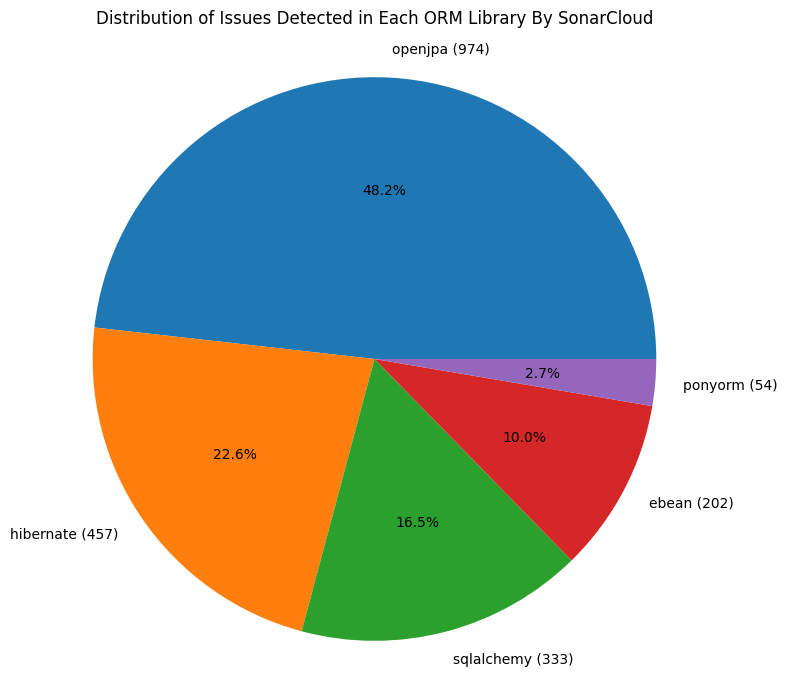

In [3]:
sonarcloud_package_proportion = sonarcloud_df['package'].value_counts()

plt.figure(figsize=(8,8))
plt.pie(sonarcloud_package_proportion, labels=[f"{index} ({sonarcloud_package_proportion[index]})" for index in sonarcloud_package_proportion.index],autopct='%1.1f%%')
plt.title('Distribution of Issues Detected in Each ORM Library By SonarCloud', pad=20)
plt.axis('equal')
plt.savefig("plots/sonar_issues_by_orm.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [4]:
sonarcloud_sample = sonarcloud_df.sample(n=24, random_state=42)
reviewer_name = ['Hashir Jamil'] * 12 + ['Zachary Ross'] * 12
sonarcloud_sample.insert(0, 'reviewer', reviewer_name)
sonarcloud_sample.to_csv('sonarcloud_data/csv/sonarcloud_sample.csv', index=False)

In [5]:
file_path_frequency_df = sonarcloud_df.groupby(['package','file_path']).size().reset_index(name='file_frequency')
file_path_frequency_df.sort_values(by=['file_frequency'], ascending=False, inplace=True)
file_path_frequency_df.reset_index(drop=True, inplace=True)
file_path_frequency_df.to_csv('sonarcloud_data/csv/sonarcloud_file_frequency.csv', index=False)
file_path_frequency_df

,package,file_path,file_frequency
0,sqlalchemy,test/perf/compiled_extensions.py,56
1,openjpa,openjpa-kernel/src/main/java/org/apache/openjp...,46
2,ebean,ebean-core/src/main/java/io/ebeaninternal/serv...,44
3,sqlalchemy,test/sql/test_operators.py,38
4,hibernate,hibernate-core/src/main/java/org/hibernate/eng...,29
...,...,...,...
647,hibernate,hibernate-core/src/main/java/org/hibernate/pro...,1
648,hibernate,hibernate-core/src/main/java/org/hibernate/per...,1
649,hibernate,hibernate-core/src/main/java/org/hibernate/per...,1
650,hibernate,hibernate-core/src/main/java/org/hibernate/per...,1


In [6]:
subsystem_frequency_df = sonarcloud_df[[ 'package','file_path']].copy()

def modify_file_path(row):
    split_path = row['file_path'].split('/')
    if row['package'] == 'sqlalchemy':
        if len(split_path) <= 3:
            return '/'.join(split_path[:2])
        else:
            return '/'.join(split_path[:3])
    elif row['package'] == 'ponyorm':
        if len(split_path) <= 3:
            return '/'.join(split_path[:2])
        else:
            return '/'.join(split_path[:3])
    else:
        return split_path[0]

subsystem_frequency_df['file_path'] = subsystem_frequency_df.apply(modify_file_path, axis=1)
subsystem_frequency_df = subsystem_frequency_df.groupby(['package','file_path']).size().reset_index(name='subsystem_frequency')
subsystem_frequency_df.sort_values(by=['subsystem_frequency'], ascending=False, inplace=True)
subsystem_frequency_df.reset_index(drop=True, inplace=True)
subsystem_frequency_df.sort_values(['package']).to_csv('sonarcloud_data/csv/sonarcloud_subsystem_frequency.csv', index=False)
subsystem_frequency_df

,package,file_path,subsystem_frequency
0,hibernate,hibernate-core,377
1,openjpa,openjpa-kernel,340
2,openjpa,openjpa-jdbc,232
3,openjpa,openjpa-persistence,158
4,ebean,ebean-core,149
...,...,...,...
59,ponyorm,pony/utils,1
60,ponyorm,pony/thirdparty,1
61,ebean,tests,1
62,ponyorm,pony/orm/dbproviders,1


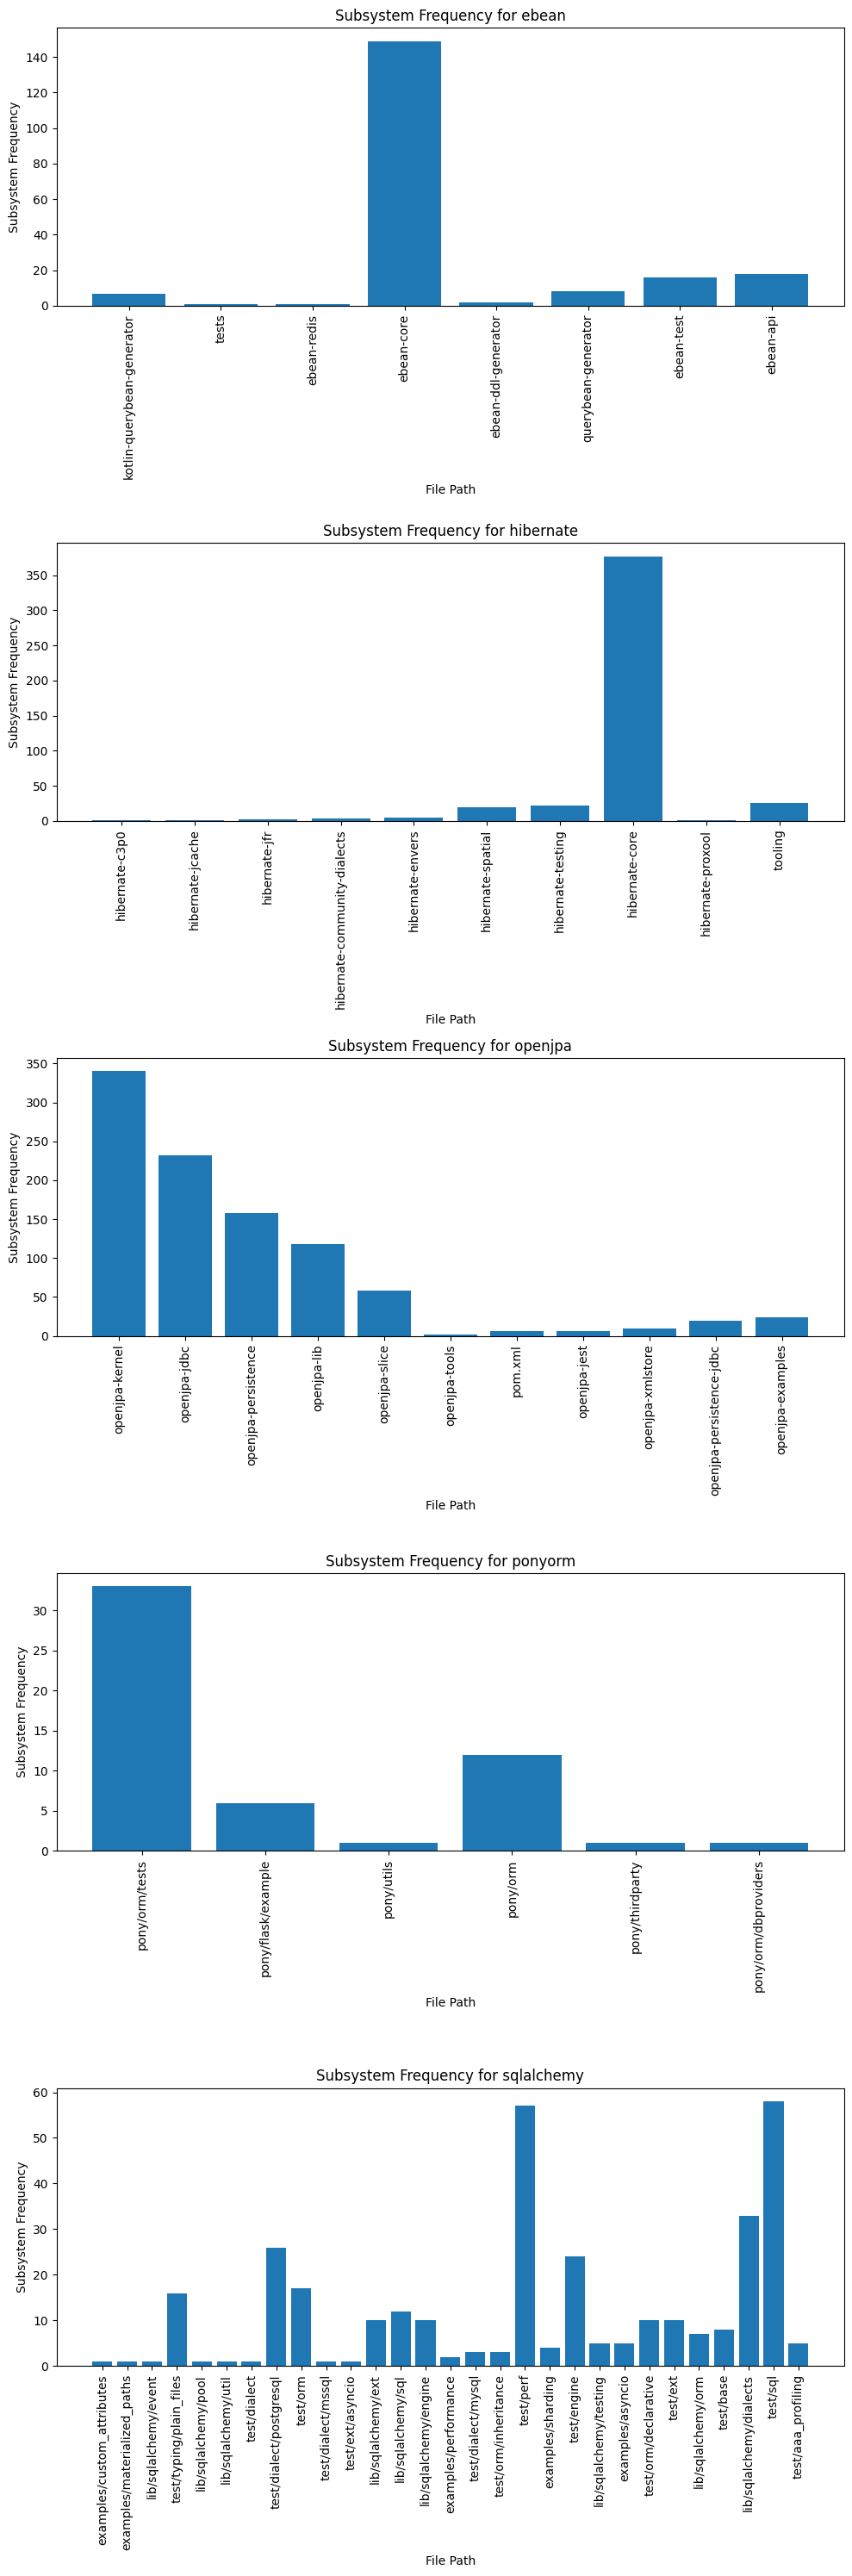

In [7]:
data = pd.read_csv('sonarcloud_data/csv/sonarcloud_subsystem_frequency.csv')

# Group data by package
grouped_data = data.groupby('package')

# Define the number of packages and set up subplots
num_packages = len(grouped_data)
fig, axs = plt.subplots(num_packages, figsize=(10, 6*num_packages))

# Plot for each package
for i, (package, group) in enumerate(grouped_data):
    # Create a subplot for each package
    ax = axs[i] if num_packages > 1 else axs

    # Plot the data for the current package
    ax.bar(group['file_path'], group['subsystem_frequency'])

    # Set labels and title for the subplot
    ax.set_xlabel('File Path')
    ax.set_ylabel('Subsystem Frequency')
    ax.set_title(f'Subsystem Frequency for {package}')

    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()

# Show and save plot
plt.savefig("plots/sonarcloud_subsystem_frequency.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [8]:
import re

def extract_subcomponent(pattern,text):
    match = re.search(pattern,text)
    if match:
        return match.group(1)
    else:
        return text
    
ebean_core_pattern = r"ebean-core/src/main/java/io/ebeaninternal/(.*?)/(?=[A-Z])"
ebean_core_df = pd.read_csv('sonarcloud_data/csv/sonarcloud_ebean.csv')
ebean_core_df = ebean_core_df[ebean_core_df['file_path'].str.contains('ebean-core') & ~ebean_core_df['file_path'].str.contains('test') & ~ebean_core_df['file_path'].str.contains('html')]
ebean_core_df['ebean_core_subcomponent'] = ebean_core_df['file_path'].apply(lambda x: extract_subcomponent(ebean_core_pattern,x))
ebean_core_df = ebean_core_df.groupby(['ebean_core_subcomponent']).size().reset_index(name='subcomponent_frequency')
ebean_core_df.sort_values(by=['subcomponent_frequency'], ascending=False, inplace=True)
ebean_core_df.reset_index(drop=True, inplace=True)
ebean_core_df.head(14)

,ebean_core_subcomponent,subcomponent_frequency
0,server/core,49
1,server/query,11
2,server/expression,10
3,server/type,6
4,server/deploy,5
5,server/persist,3
6,server/querydefn,3
7,server/deploy/meta,2
8,server/executor,2
9,server/persist/dml,2


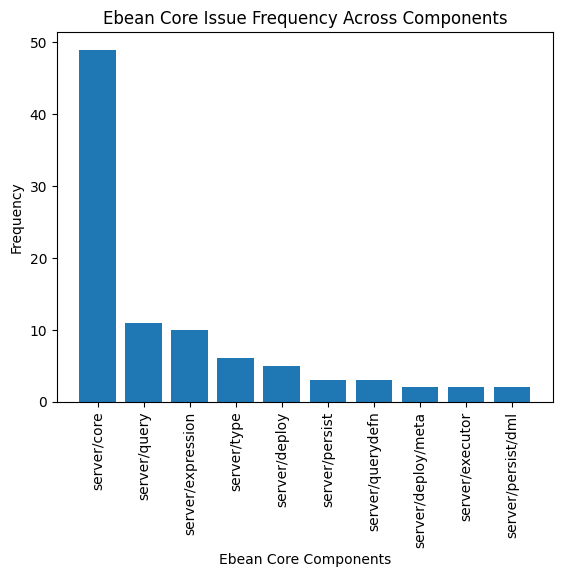

In [9]:
ebean_core_df = ebean_core_df.nlargest(10,'subcomponent_frequency')
plt.bar(ebean_core_df['ebean_core_subcomponent'], ebean_core_df['subcomponent_frequency'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel('Ebean Core Components')
plt.ylabel('Frequency')
plt.title('Ebean Core Issue Frequency Across Components')
plt.show()

In [10]:
hibernate_core_pattern = r"hibernate-core/src/main/java/org/hibernate/(.*?)/(?=[A-Z])"  
hibernate_core_df = pd.read_csv('sonarcloud_data/csv/sonarcloud_hibernate-orm.csv')
hibernate_core_df = hibernate_core_df[hibernate_core_df['file_path'].str.contains('hibernate-core') & ~hibernate_core_df['file_path'].str.contains('test')]
hibernate_core_df['hibernate_core_subcomponent'] = hibernate_core_df['file_path'].apply(lambda x: extract_subcomponent(hibernate_core_pattern,x))
hibernate_core_df = hibernate_core_df.groupby(['hibernate_core_subcomponent']).size().reset_index(name='subcomponent_frequency')
hibernate_core_df.sort_values(by=['subcomponent_frequency'], ascending=False, inplace=True)
hibernate_core_df.reset_index(drop=True, inplace=True)
hibernate_core_df.head(96)

,hibernate_core_subcomponent,subcomponent_frequency
0,engine/internal,66
1,event/internal,29
2,internal,23
3,dialect,16
4,boot/model/internal,12
...,...,...
80,proxy/map,1
81,proxy/pojo/bytebuddy,1
82,query/criteria,1
83,query/criteria/internal,1


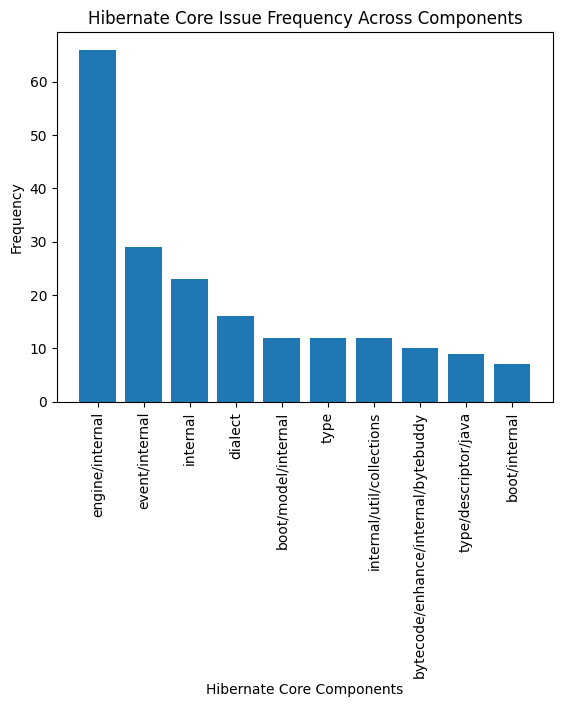

In [11]:
hibernate_core_df_top10 = hibernate_core_df.nlargest(10,'subcomponent_frequency')
plt.bar(hibernate_core_df_top10['hibernate_core_subcomponent'], hibernate_core_df_top10['subcomponent_frequency'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel('Hibernate Core Components')
plt.ylabel('Frequency')
plt.title('Hibernate Core Issue Frequency Across Components')
plt.show()

In [12]:
openjpa_core_pattern = r"openjpa-kernel/src/main/java/org/apache/openjpa/(.*?)/(?=[A-Z])"
openjpa_core_df = pd.read_csv('sonarcloud_data/csv/sonarcloud_openjpa.csv')
openjpa_core_df = openjpa_core_df[openjpa_core_df['file_path'].str.contains('openjpa-kernel') & ~openjpa_core_df['file_path'].str.contains('html')]
openjpa_core_df['openjpa_core_subcomponent'] = openjpa_core_df['file_path'].apply(lambda x: extract_subcomponent(openjpa_core_pattern,x))
openjpa_core_df = openjpa_core_df.groupby(['openjpa_core_subcomponent']).size().reset_index(name='subcomponent_frequency')
openjpa_core_df.sort_values(by=['subcomponent_frequency'], ascending=False, inplace=True)
openjpa_core_df.reset_index(drop=True, inplace=True)
openjpa_core_df

,openjpa_core_subcomponent,subcomponent_frequency
0,kernel,52
1,enhance,26
2,meta,12
3,event,10
4,util,10
5,kernel/exps,7
6,kernel/jpql,5
7,util/proxy,3
8,conf,2
9,datacache,2


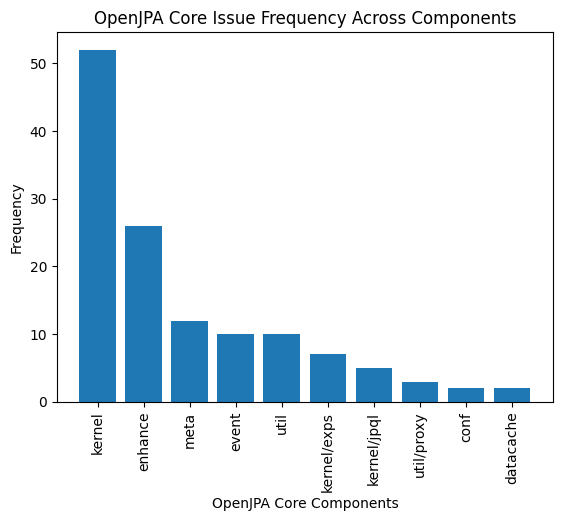

In [13]:
openjpa_core_df = openjpa_core_df.nlargest(10,'subcomponent_frequency')
plt.bar(openjpa_core_df['openjpa_core_subcomponent'], openjpa_core_df['subcomponent_frequency'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel('OpenJPA Core Components')
plt.ylabel('Frequency')
plt.title('OpenJPA Core Issue Frequency Across Components')
plt.show()

In [14]:
# File Extension Analysis
def extract_extension(file_path):
    return file_path.split('.')[-1]

# Create a dictionary to store the frequency of file extensions
extension_frequency = {}

# Iterate over each row of the DataFrame
for index, row in sonarcloud_df.iterrows():
    # Extract the file extension
    extension = extract_extension(row['file_path'])
    # Increment the frequency count for the file extension
    extension_frequency[extension] = extension_frequency.get(extension, 0) + 1

# Create a DataFrame from the dictionary of extension frequencies
extension_df = pd.DataFrame(list(extension_frequency.items()), columns=['file_extension', 'frequency'])
extension_df.sort_values(by='frequency', inplace=True, ascending=False)
extension_df

,file_extension,frequency
1,java,1285
4,py,381
0,html,324
2,sql,24
3,xml,6


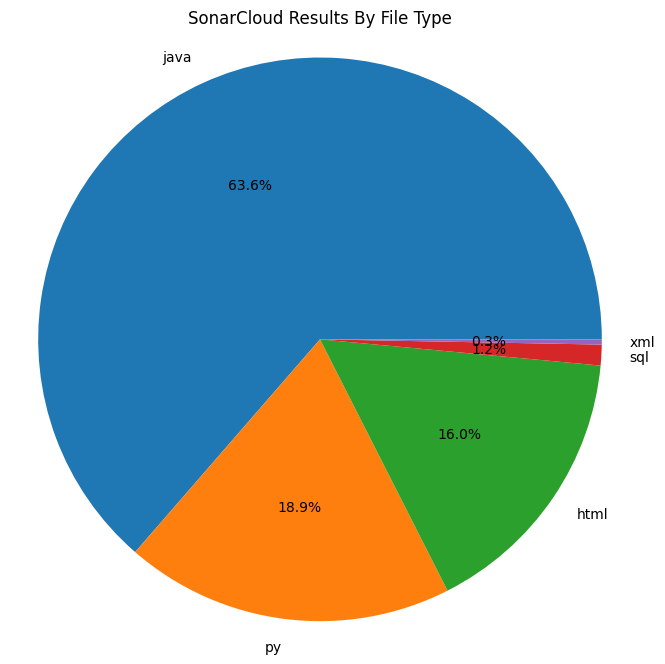

In [15]:
plt.figure(figsize=(8, 8))
plt.pie(extension_df['frequency'], labels=extension_df['file_extension'], autopct='%1.1f%%')
plt.title('SonarCloud Results By File Type')
plt.axis('equal')
plt.savefig('plots/sonarcloud_results_file_type.pdf')
plt.show()

## Coverity Data
This data is available as raw csv files.

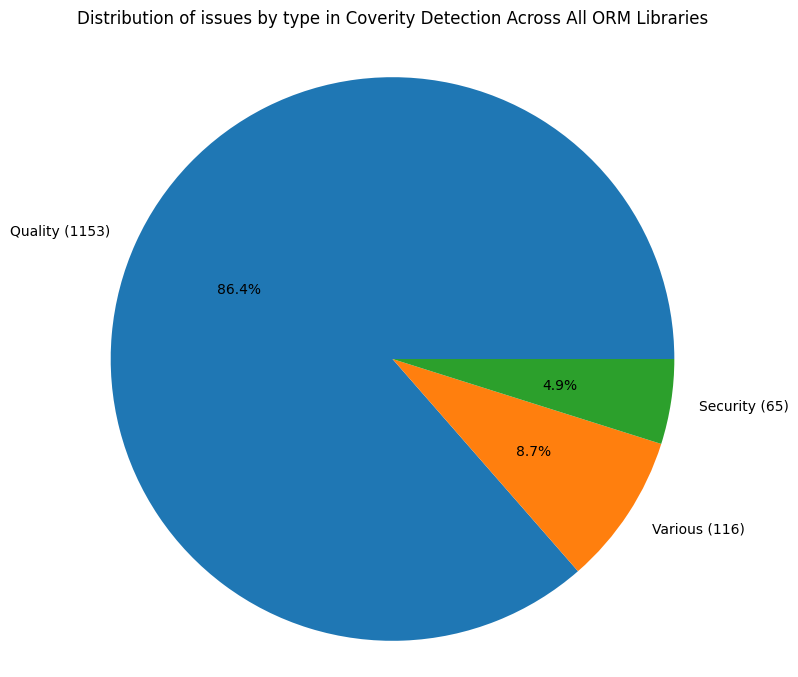

In [16]:
csv_paths = [
    "coverity_data/coverity_ebean.csv",
    "coverity_data/coverity_hibernate-orm.csv",
    "coverity_data/coverity_openjpa.csv",
    "coverity_data/coverity_ponyorm.csv",
    "coverity_data/coverity_sqlalchemy.csv"
]

ebean_df = pd.read_csv(csv_paths[0])
ebean_df['package'] = 'ebean'
hibernate_df = pd.read_csv(csv_paths[1])
hibernate_df['package'] = 'hibernate'
openjpa_df = pd.read_csv(csv_paths[2])
openjpa_df['package'] = 'openjpa'
ponyorm_df = pd.read_csv(csv_paths[3])
ponyorm_df['package'] = 'ponyorm'
sqlalchemy_df = pd.read_csv(csv_paths[4])
sqlalchemy_df['package'] = 'sqlalchemy'

coverity_df = pd.concat([ebean_df, hibernate_df, openjpa_df, openjpa_df, ponyorm_df, sqlalchemy_df], ignore_index=True)
coverity_df = coverity_df[['package','file_path','line_number','type','severity','description']]
coverity_df['file_path'] = coverity_df['file_path'].apply(lambda x:x[1:])
coverity_df.to_csv('coverity_data/coverity_results.csv', index=False)

coverity_type_proportion = coverity_df['type'].value_counts()

plt.figure(figsize=(8,8))
plt.pie(coverity_type_proportion, labels=[f"{index} ({coverity_type_proportion[index]})" for index in coverity_type_proportion.index],autopct='%1.1f%%')
plt.title('Distribution of issues by type in Coverity Detection Across All ORM Libraries', pad=20)
plt.axis('equal')
plt.savefig("plots/coverity_issue_type_distribution.pdf", format="pdf", bbox_inches="tight")
plt.show()

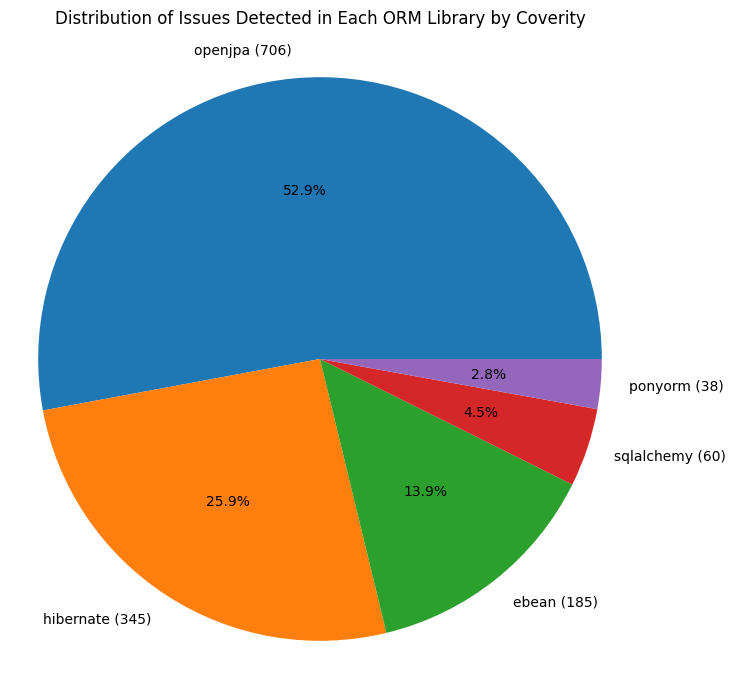

In [17]:
coverity_package_proportion = coverity_df['package'].value_counts()

plt.figure(figsize=(8,8))
plt.pie(coverity_package_proportion, labels=[f"{index} ({coverity_package_proportion[index]})" for index in coverity_package_proportion.index],autopct='%1.1f%%')
plt.title('Distribution of Issues Detected in Each ORM Library by Coverity', pad=20)
plt.axis('equal')
plt.savefig("plots/coverity_issues_by_orm.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [18]:
coverity_sample = coverity_df.sample(n=24, random_state=42)
reviewer_name = ['Erika Grandy'] * 12 + ['Natalie Dean'] * 12
coverity_sample.insert(0, 'reviewer', reviewer_name)
coverity_sample.to_csv('coverity_data/coverity_sample.csv', index=False)

In [19]:
coverity_file_frequency_df = coverity_df.groupby(['package','file_path']).size().reset_index(name='file_frequency')
coverity_file_frequency_df.sort_values(by=['file_frequency'], ascending=False, inplace=True)
coverity_file_frequency_df.reset_index(drop=True, inplace=True)
coverity_file_frequency_df.to_csv('coverity_data/coverity_file_frequency.csv', index=False)
coverity_file_frequency_df

,package,file_path,file_frequency
0,openjpa,openjpa-kernel/src/main/java/org/apache/openjp...,48
1,openjpa,openjpa-kernel/src/main/java/org/apache/openjp...,24
2,sqlalchemy,setup.cfg,20
3,hibernate,hibernate-core/src/main/java/org/hibernate/dia...,18
4,openjpa,openjpa-slice/src/main/java/org/apache/openjpa...,18
...,...,...,...
543,hibernate,hibernate-core/src/main/java/org/hibernate/map...,1
544,hibernate,hibernate-core/src/main/java/org/hibernate/loa...,1
545,hibernate,hibernate-core/src/main/java/org/hibernate/loa...,1
546,hibernate,hibernate-core/src/main/java/org/hibernate/loa...,1


In [20]:
coverity_subsystem_frequency_df = coverity_df[[ 'package','file_path']].copy()
coverity_subsystem_frequency_df['file_path'] = coverity_subsystem_frequency_df.apply(modify_file_path, axis=1)
coverity_subsystem_frequency_df = coverity_subsystem_frequency_df.groupby(['package','file_path']).size().reset_index(name='subsystem_frequency')
coverity_subsystem_frequency_df.sort_values(by=['subsystem_frequency'], ascending=False, inplace=True)
coverity_subsystem_frequency_df.reset_index(drop=True, inplace=True)
coverity_subsystem_frequency_df.sort_values(['package']).to_csv('coverity_data/coverity_subsystem_frequency.csv', index=False)
coverity_subsystem_frequency_df

,package,file_path,subsystem_frequency
0,hibernate,hibernate-core,281
1,openjpa,openjpa-kernel,258
2,openjpa,openjpa-jdbc,202
3,ebean,ebean-core,134
4,openjpa,openjpa-lib,58
5,openjpa,openjpa-persistence,58
6,openjpa,openjpa-slice,36
7,openjpa,openjpa-examples,36
8,ponyorm,pony/orm,31
9,sqlalchemy,setup.cfg,20


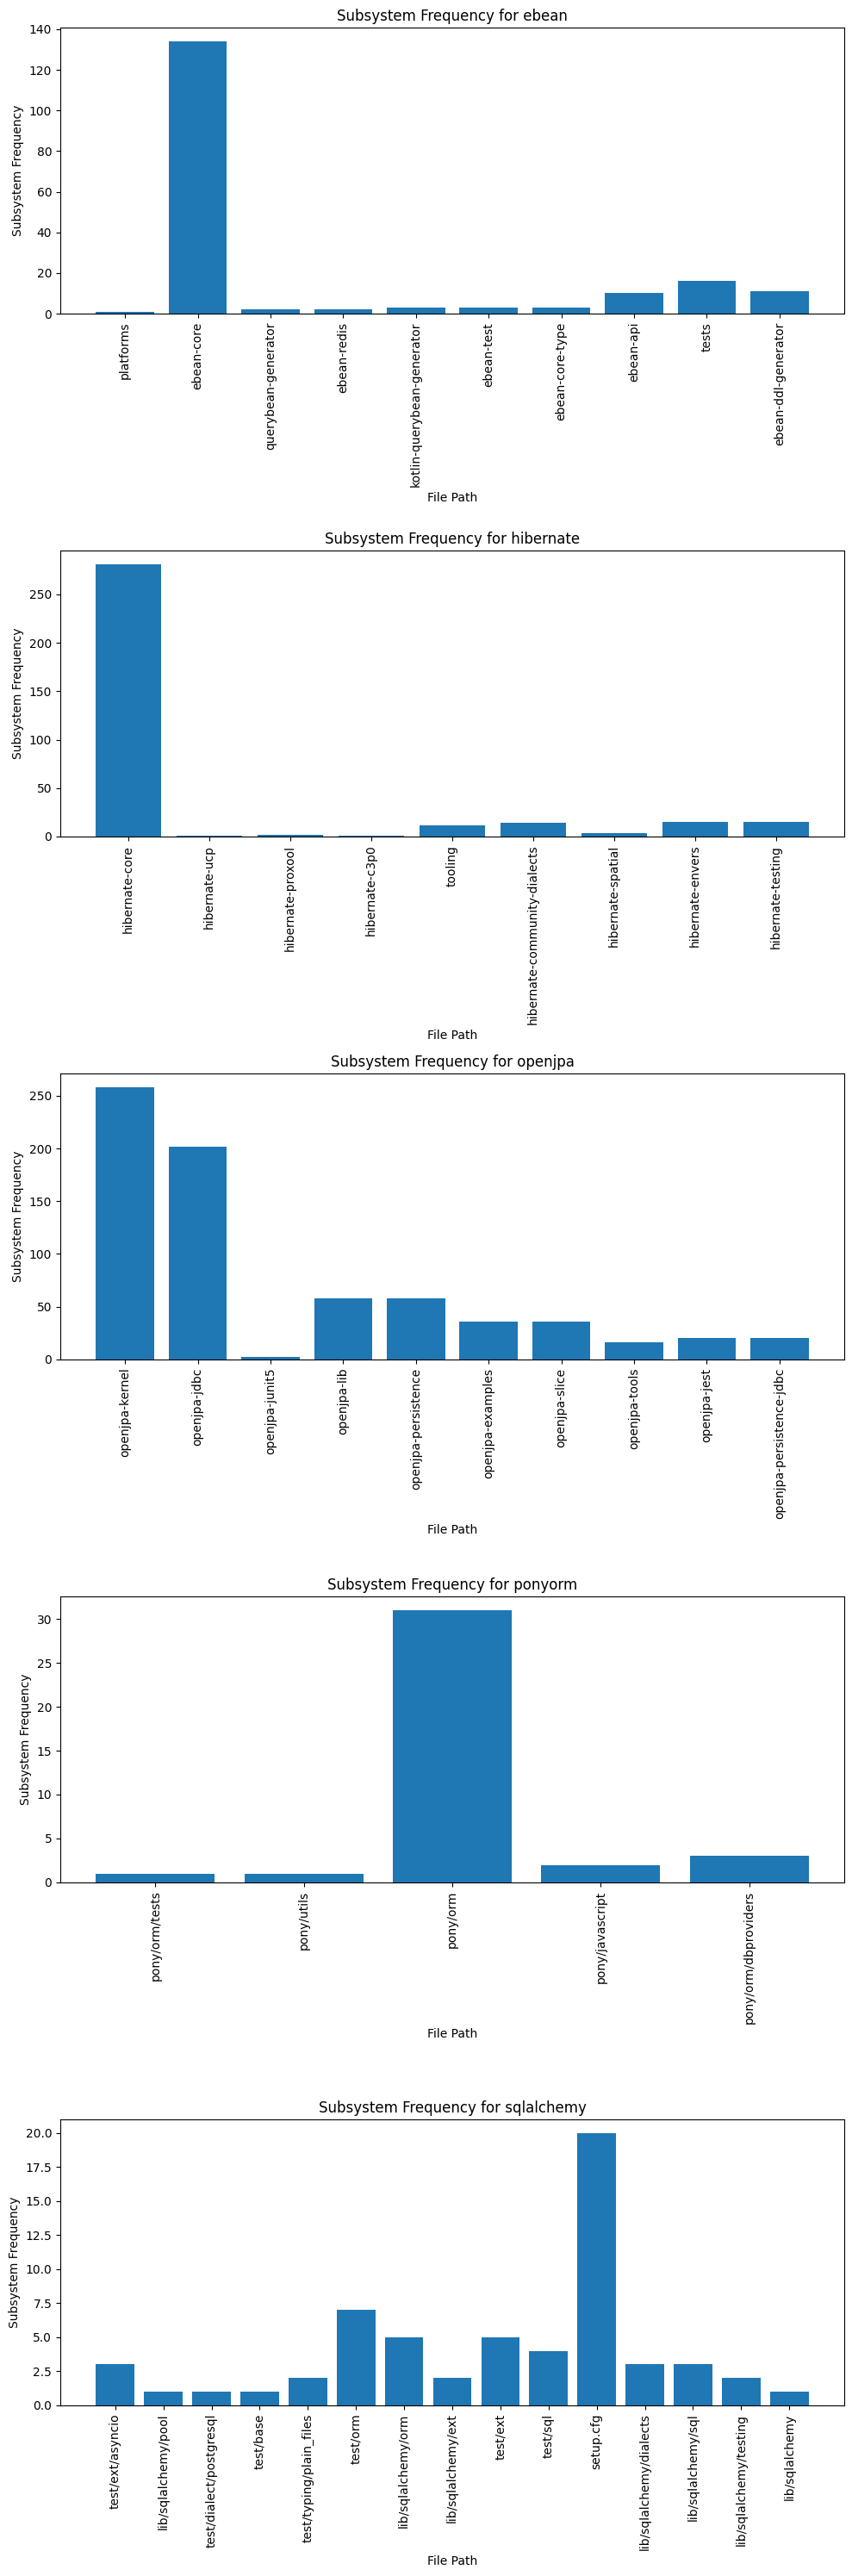

In [21]:
data = pd.read_csv('coverity_data/coverity_subsystem_frequency.csv')

# Group data by package
grouped_data = data.groupby('package')

# Define the number of packages and set up subplots
num_packages = len(grouped_data)
fig, axs = plt.subplots(num_packages, figsize=(10, 6*num_packages))

# Plot for each package
for i, (package, group) in enumerate(grouped_data):
    # Create a subplot for each package
    ax = axs[i] if num_packages > 1 else axs

    # Plot the data for the current package
    ax.bar(group['file_path'], group['subsystem_frequency'])

    # Set labels and title for the subplot
    ax.set_xlabel('File Path')
    ax.set_ylabel('Subsystem Frequency')
    ax.set_title(f'Subsystem Frequency for {package}')

    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()

# Show plot
plt.savefig("plots/coverity_subsystem_frequency.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [22]:
ebean_core_pattern = r"ebean-core/src/main/java/io/ebeaninternal/(.*?)/(?=[A-Z])"
ebean_core_df = pd.read_csv('coverity_data/coverity_ebean.csv')
ebean_core_df = ebean_core_df[
    ebean_core_df['file_path'].str.contains('ebean-core') & ~ebean_core_df['file_path'].str.contains('test') & ~
    ebean_core_df['file_path'].str.contains('html')]
ebean_core_df['ebean_core_subcomponent'] = ebean_core_df['file_path'].apply(
    lambda x: extract_subcomponent(ebean_core_pattern, x))
ebean_core_df = ebean_core_df.groupby(['ebean_core_subcomponent']).size().reset_index(name='subcomponent_frequency')
ebean_core_df.sort_values(by=['subcomponent_frequency'], ascending=False, inplace=True)
ebean_core_df.reset_index(drop=True, inplace=True)
ebean_core_df.head(20)

,ebean_core_subcomponent,subcomponent_frequency
0,server/query,37
1,server/deploy,19
2,server/core,12
3,server/persist,9
4,server/type,8
5,server/transaction,6
6,server/deploy/id,5
7,server/querydefn,5
8,server/dto,4
9,server/idgen,4


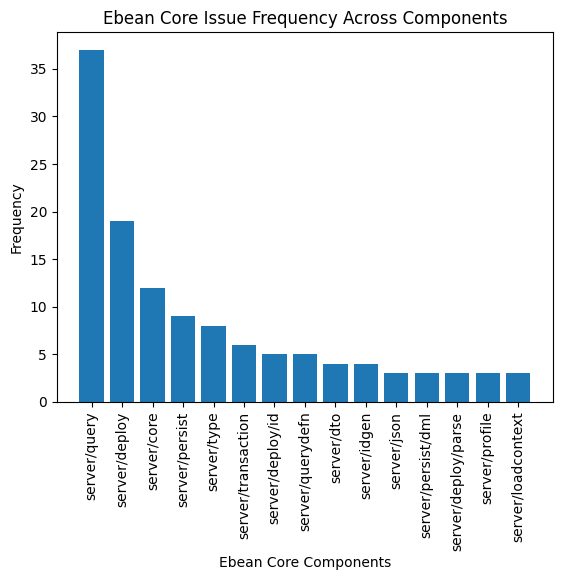

In [23]:
ebean_core_df = ebean_core_df.nlargest(15,'subcomponent_frequency')
plt.bar(ebean_core_df['ebean_core_subcomponent'], ebean_core_df['subcomponent_frequency'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel('Ebean Core Components')
plt.ylabel('Frequency')
plt.title('Ebean Core Issue Frequency Across Components')
plt.show()

In [24]:
hibernate_core_pattern = r"hibernate-core/src/main/java/org/hibernate/(.*?)/(?=[A-Z])"
hibernate_core_df = pd.read_csv('coverity_data/coverity_hibernate-orm.csv')
hibernate_core_df = hibernate_core_df[hibernate_core_df['file_path'].str.contains('hibernate-core')]
hibernate_core_df['hibernate_core_subcomponent'] = hibernate_core_df['file_path'].apply(
    lambda x: extract_subcomponent(hibernate_core_pattern, x))
hibernate_core_df = hibernate_core_df.groupby(['hibernate_core_subcomponent']).size().reset_index(
    name='subcomponent_frequency')
hibernate_core_df.sort_values(by=['subcomponent_frequency'], ascending=False, inplace=True)
hibernate_core_df.reset_index(drop=True, inplace=True)
hibernate_core_df.head(96)

,hibernate_core_subcomponent,subcomponent_frequency
0,dialect,44
1,boot/model/internal,17
2,boot/jaxb/hbm/transform,9
3,sql/ast/spi,9
4,mapping,8
...,...,...
81,query/sqm/tree/select,1
82,resource/transaction/backend/jta/internal,1
83,service/internal,1
84,sql,1


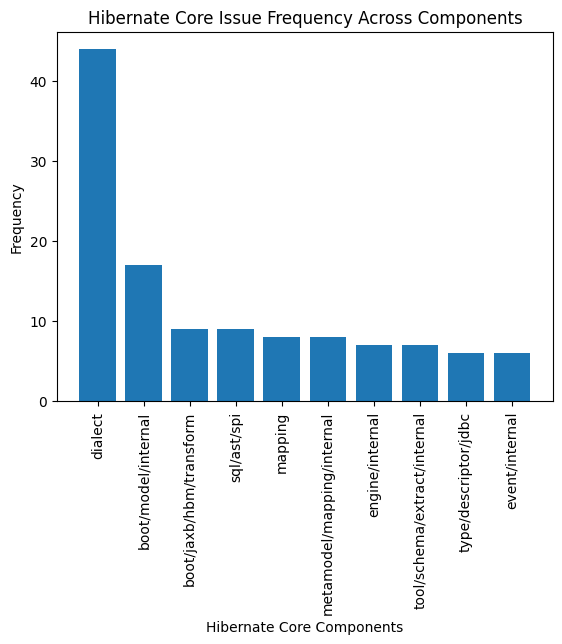

In [25]:
hibernate_core_df_top10 = hibernate_core_df.nlargest(10, 'subcomponent_frequency')
plt.bar(hibernate_core_df_top10['hibernate_core_subcomponent'], hibernate_core_df_top10['subcomponent_frequency'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel('Hibernate Core Components')
plt.ylabel('Frequency')
plt.title('Hibernate Core Issue Frequency Across Components')
plt.show()

In [26]:
openjpa_core_pattern = r"openjpa-kernel/src/main/java/org/apache/openjpa/(.*?)/(?=[A-Z])"
openjpa_core_df = pd.read_csv('coverity_data/coverity_openjpa.csv')
openjpa_core_df = openjpa_core_df[
    openjpa_core_df['file_path'].str.contains('openjpa-kernel') & ~openjpa_core_df['file_path'].str.contains('html') & ~openjpa_core_df['file_path'].str.contains('target')]
openjpa_core_df['openjpa_core_subcomponent'] = openjpa_core_df['file_path'].apply(
    lambda x: extract_subcomponent(openjpa_core_pattern, x))
openjpa_core_df = openjpa_core_df.groupby(['openjpa_core_subcomponent']).size().reset_index(
    name='subcomponent_frequency')
openjpa_core_df.sort_values(by=['subcomponent_frequency'], ascending=False, inplace=True)
openjpa_core_df.reset_index(drop=True, inplace=True)
openjpa_core_df.head(11)

,openjpa_core_subcomponent,subcomponent_frequency
0,kernel,58
1,enhance,12
2,kernel/jpql,12
3,meta,10
4,datacache,9
5,event,9
6,util,8
7,kernel/exps,6
8,conf,2
9,ee,1


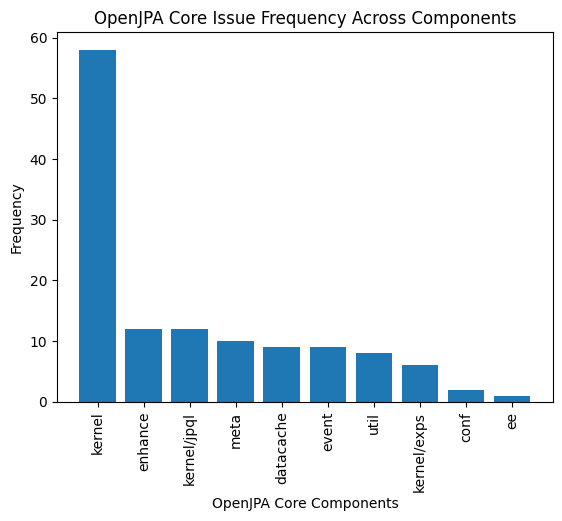

In [27]:
openjpa_core_df = openjpa_core_df.nlargest(10, 'subcomponent_frequency')
plt.bar(openjpa_core_df['openjpa_core_subcomponent'], openjpa_core_df['subcomponent_frequency'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel('OpenJPA Core Components')
plt.ylabel('Frequency')
plt.title('OpenJPA Core Issue Frequency Across Components')
plt.show()

In [28]:
# File Extension Analysis
def extract_extension(file_path):
    return file_path.split('.')[-1]

# Create a dictionary to store the frequency of file extensions
extension_frequency = {}

# Iterate over each row of the DataFrame
for index, row in coverity_df.iterrows():
    # Extract the file extension
    extension = extract_extension(row['file_path'])
    # Increment the frequency count for the file extension
    extension_frequency[extension] = extension_frequency.get(extension, 0) + 1

# Create a DataFrame from the dictionary of extension frequencies
extension_df = pd.DataFrame(list(extension_frequency.items()), columns=['file_extension', 'frequency'])
extension_df.sort_values(by='frequency', inplace=True, ascending=False)
extension_df

,file_extension,frequency
0,java,1236
1,py,76
3,cfg,20
2,js,2


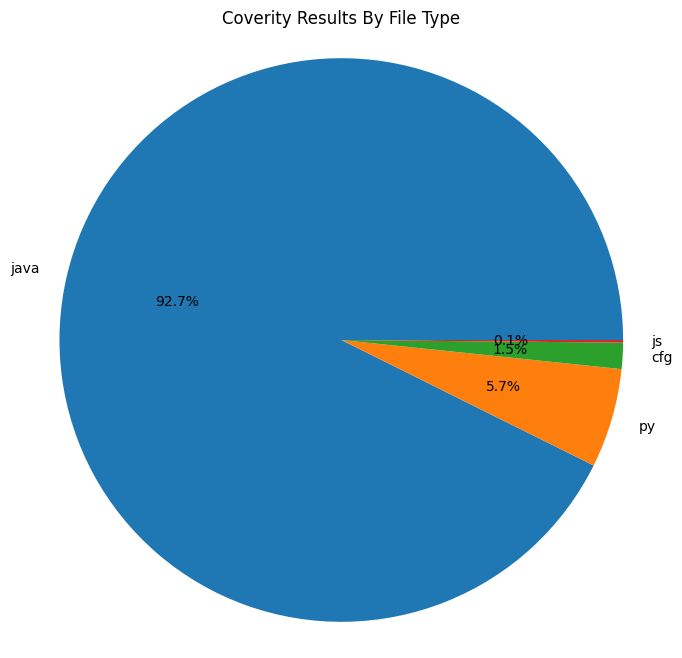

In [29]:
plt.figure(figsize=(8, 8))
plt.pie(extension_df['frequency'], labels=extension_df['file_extension'], autopct='%1.1f%%')
plt.title('Coverity Results By File Type')
plt.axis('equal')
plt.savefig('plots/coverity_results_file_type.pdf')
plt.show()

## SNYK Data
This data is available as raw csv files.

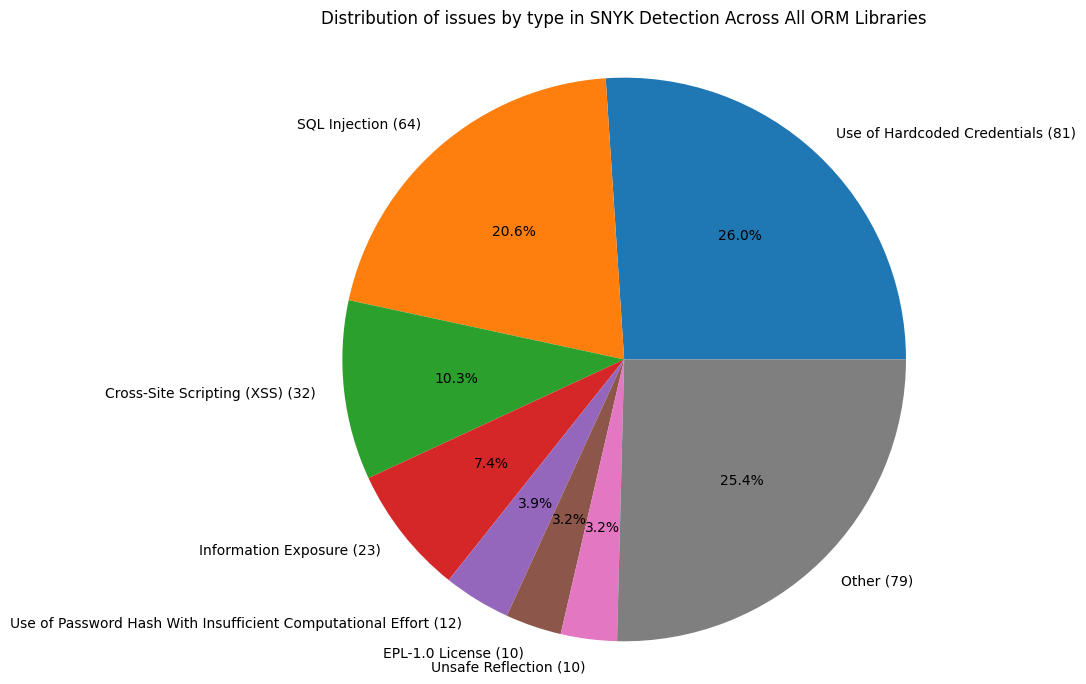

type
Use of Hardcoded Credentials                                         81
SQL Injection                                                        64
Cross-Site Scripting (XSS)                                           32
Information Exposure                                                 23
Use of Password Hash With Insufficient Computational Effort          12
EPL-1.0 License                                                      10
Unsafe Reflection                                                    10
Dual License: EPL -1.0, MPL-2.0                                       8
Remote Code Execution (RCE)                                           8
LDAP Injection                                                        6
Denial of Service (DoS)                                               5
Path Traversal                                                        5
LGPL-2.0 license                                                      4
XML External Entity (XXE) Injection                        

In [30]:
csv_paths = [
    "snyk_data/snyk_ebean.csv",
    "snyk_data/snyk_hibernate-orm.csv",
    "snyk_data/snyk_openjpa.csv",
    "snyk_data/snyk_ponyorm.csv",
    "snyk_data/snyk_sqlalchemy.csv"
]

ebean_df = pd.read_csv(csv_paths[0])
ebean_df['package'] = 'ebean'
hibernate_df = pd.read_csv(csv_paths[1])
hibernate_df['package'] = 'hibernate'
openjpa_df = pd.read_csv(csv_paths[2])
openjpa_df['package'] = 'openjpa'
ponyorm_df = pd.read_csv(csv_paths[3])
ponyorm_df['package'] = 'ponyorm'
sqlalchemy_df = pd.read_csv(csv_paths[4])
sqlalchemy_df['package'] = 'sqlalchemy'

snyk_df = pd.concat([ebean_df, hibernate_df, openjpa_df, openjpa_df, ponyorm_df, sqlalchemy_df], ignore_index=True)
snyk_df = snyk_df[['package','file_path','line_number','type','severity','description']]
snyk_df['file_path'] = snyk_df['file_path'].apply(lambda x: x.split('/',1)[1] if '/' in x else x)
snyk_df['file_path'] = snyk_df['file_path'].apply(lambda x: x.replace('?',''))
snyk_df.to_csv('snyk_data/snyk_results.csv', index=False)

snyk_type_proportion = snyk_df['type'].value_counts()
filtered_snyk = snyk_type_proportion[snyk_type_proportion >= 10]
total_others = snyk_type_proportion[snyk_type_proportion < 10].sum()
filtered_snyk = filtered_snyk._append(pd.Series(total_others,index=['Other']))

plt.figure(figsize=(8,8))
plt.pie(filtered_snyk, labels=[f"{index} ({filtered_snyk[index]})" for index in filtered_snyk.index],autopct='%1.1f%%')
plt.title('Distribution of issues by type in SNYK Detection Across All ORM Libraries', pad=20)
plt.axis('equal')
plt.savefig("plots/snyk_issue_type_distribution.pdf", format="pdf", bbox_inches="tight")
plt.show()

snyk_type_proportion

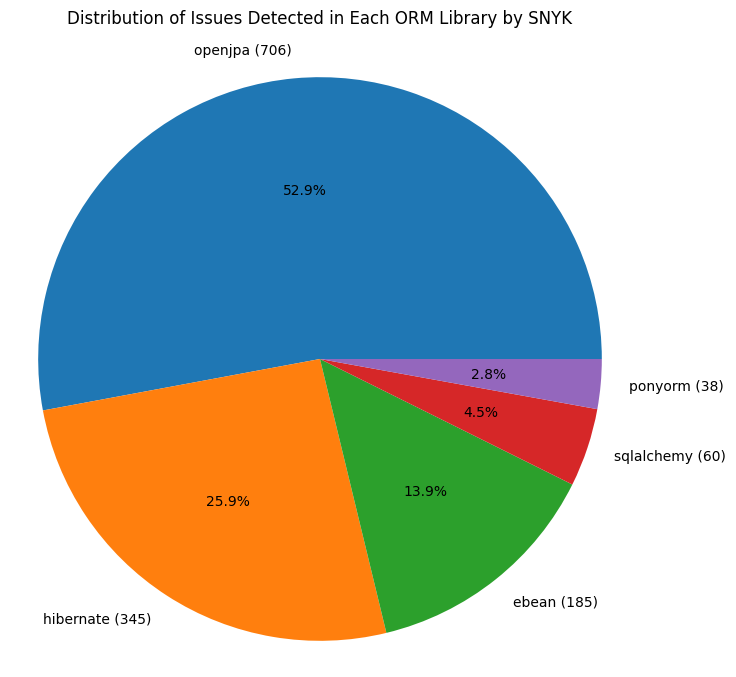

In [31]:
snyk_package_proportion = snyk_df['package'].value_counts()

plt.figure(figsize=(8,8))
plt.pie(coverity_package_proportion, labels=[f"{index} ({coverity_package_proportion[index]})" for index in coverity_package_proportion.index],autopct='%1.1f%%')
plt.title('Distribution of Issues Detected in Each ORM Library by SNYK', pad=20)
plt.axis('equal')
plt.savefig("plots/snyk_issues_by_orm.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [32]:
snyk_sample = snyk_df.sample(n=22, random_state=42)
reviewer_name = ['Krishna Raju'] * 11 + ['Michael Sandrin'] * 11
snyk_sample.insert(0, 'reviewer', reviewer_name)
snyk_sample.to_csv('snyk_data/snyk_sample.csv', index=False)

In [33]:
snyk_file_frequency_df = snyk_df.groupby(['package', 'file_path']).size().reset_index(name='file_frequency')
snyk_file_frequency_df.sort_values(by=['file_frequency'], ascending=False, inplace=True)
snyk_file_frequency_df.reset_index(drop=True, inplace=True)
snyk_file_frequency_df.to_csv('snyk_data/snyk_file_frequency.csv', index=False)
snyk_file_frequency_df

,package,file_path,file_frequency
0,sqlalchemy,test/orm/test_naturalpks.py,37
1,openjpa,openbooks/pom.xml,14
2,openjpa,openjpa-tools/openjpa-maven-plugin/pom.xml,12
3,openjpa,openjpa-examples/openbooks/web/query.jsp,12
4,openjpa,openjpa-jest/src/main/java/org/apache/openjpa/...,10
...,...,...,...
95,hibernate,hibernate-core/src/test/java/org/hibernate/orm...,1
96,hibernate,hibernate-core/src/test/java/org/hibernate/orm...,1
97,hibernate,hibernate-core/src/test/java/org/hibernate/orm...,1
98,hibernate,hibernate-core/src/test/java/org/hibernate/orm...,1


In [34]:
snyk_subsystem_frequency_df = snyk_df[[ 'package','file_path']].copy()
snyk_subsystem_frequency_df['file_path'] = snyk_subsystem_frequency_df.apply(modify_file_path, axis=1)
snyk_subsystem_frequency_df = snyk_subsystem_frequency_df.groupby(['package','file_path']).size().reset_index(name='subsystem_frequency')
snyk_subsystem_frequency_df.sort_values(by=['subsystem_frequency'], ascending=False, inplace=True)
snyk_subsystem_frequency_df.reset_index(drop=True, inplace=True)
snyk_subsystem_frequency_df.sort_values(['package']).to_csv('snyk_data/snyk_subsystem_frequency.csv', index=False)
snyk_subsystem_frequency_df

,package,file_path,subsystem_frequency
0,hibernate,hibernate-core,52
1,sqlalchemy,test/orm,42
2,openjpa,openjpa-examples,30
3,hibernate,hibernate-testing,21
4,openjpa,openjpa-tools,16
5,openjpa,openbooks,14
6,openjpa,openjpa-jdbc,14
7,openjpa,openjpa-integration,12
8,ponyorm,pony/orm/tests,11
9,openjpa,openjpa-jest,10


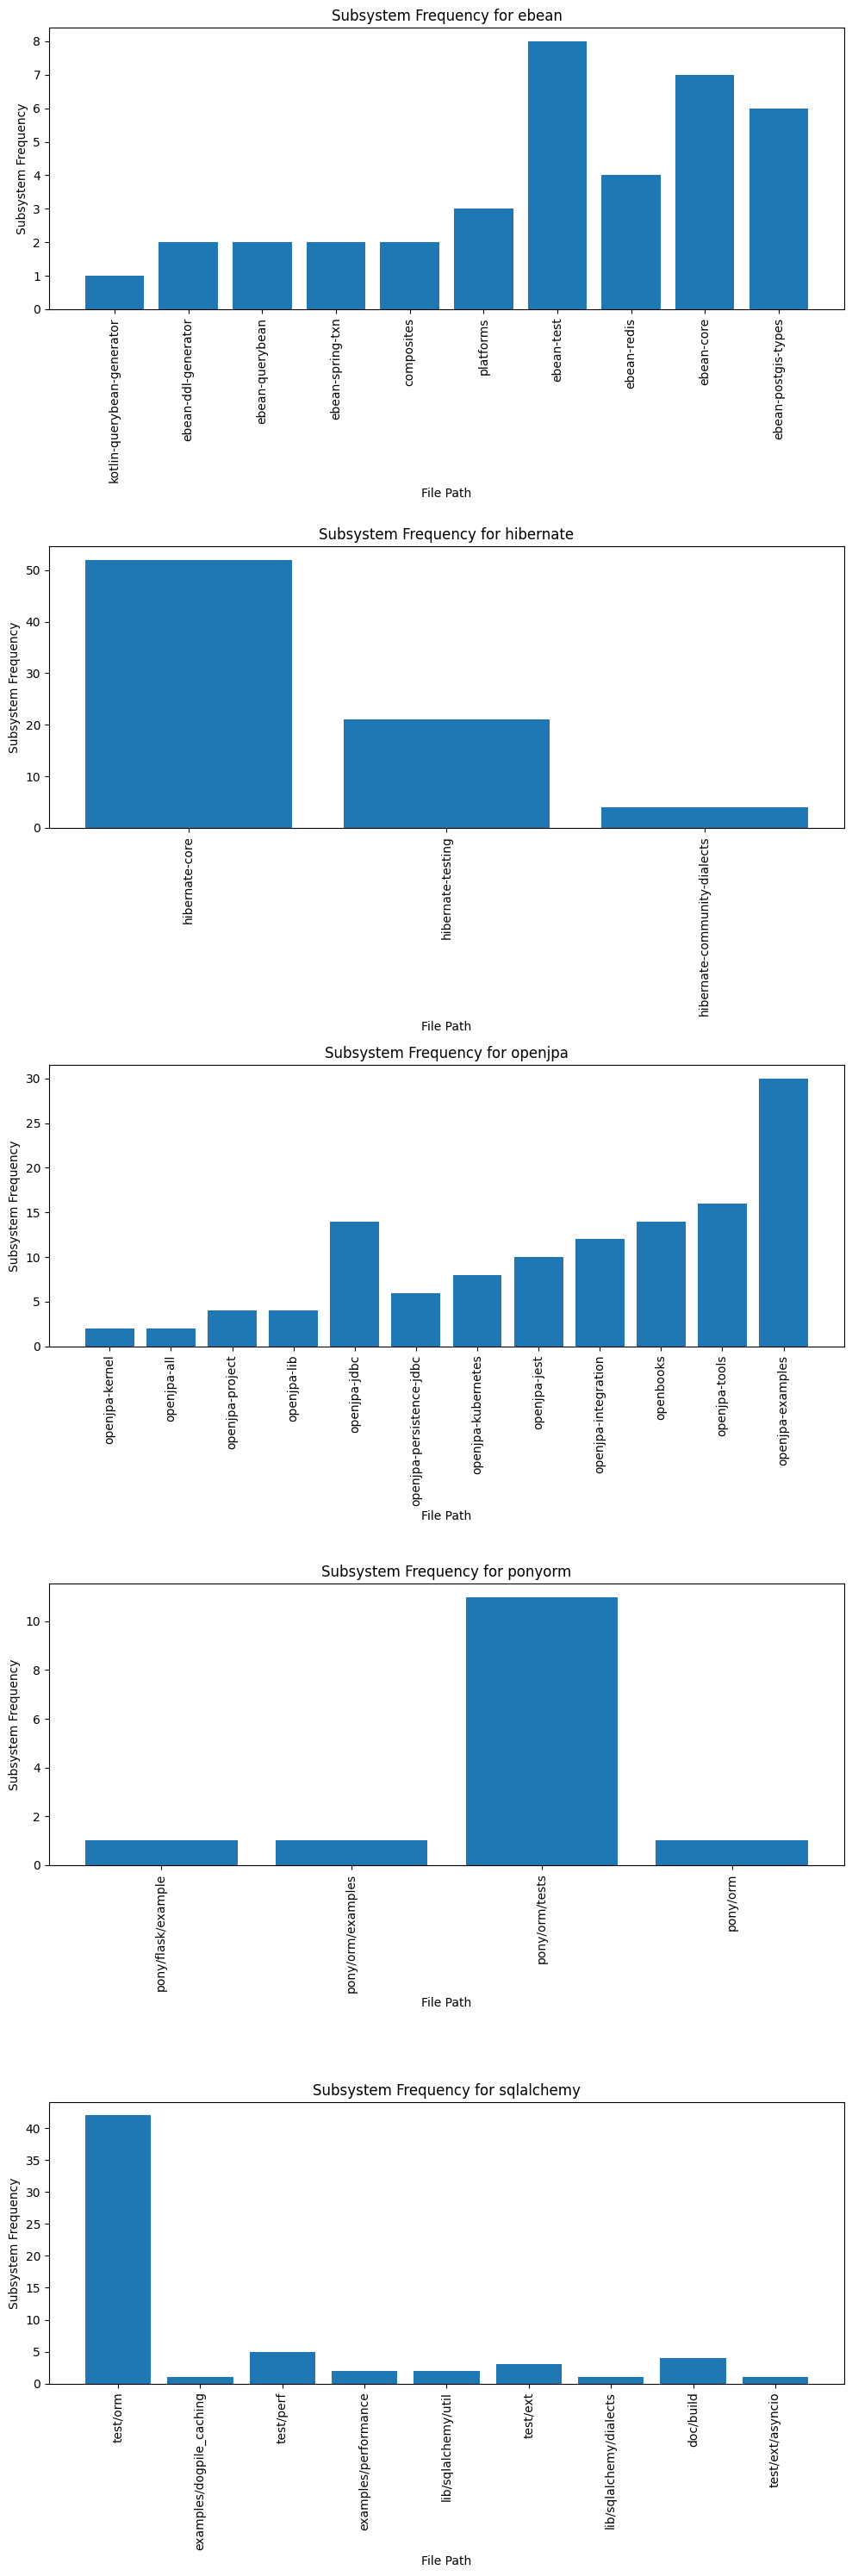

In [35]:
data = pd.read_csv('snyk_data/snyk_subsystem_frequency.csv')

# Group data by package
grouped_data = data.groupby('package')

# Define the number of packages and set up subplots
num_packages = len(grouped_data)
fig, axs = plt.subplots(num_packages, figsize=(10, 6*num_packages))

# Plot for each package
for i, (package, group) in enumerate(grouped_data):
    # Create a subplot for each package
    ax = axs[i] if num_packages > 1 else axs

    # Plot the data for the current package
    ax.bar(group['file_path'], group['subsystem_frequency'])

    # Set labels and title for the subplot
    ax.set_xlabel('File Path')
    ax.set_ylabel('Subsystem Frequency')
    ax.set_title(f'Subsystem Frequency for {package}')

    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()

# Show plot
plt.savefig("plots/snyk_subsystem_frequency.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [36]:
ebean_core_pattern = r"ebean/ebean-core/src/main/java/io/ebeaninternal/(.*?)/(?=[A-Z])"
ebean_core_df = pd.read_csv('snyk_data/snyk_ebean.csv')
ebean_core_df = ebean_core_df[
    ebean_core_df['file_path'].str.contains('ebean-core') & ~ebean_core_df['file_path'].str.contains('test') & ~
    ebean_core_df['file_path'].str.contains('html')]
ebean_core_df['ebean_core_subcomponent'] = ebean_core_df['file_path'].apply(
    lambda x: extract_subcomponent(ebean_core_pattern, x))
ebean_core_df = ebean_core_df.groupby(['ebean_core_subcomponent']).size().reset_index(name='subcomponent_frequency')
ebean_core_df.sort_values(by=['subcomponent_frequency'], ascending=False, inplace=True)
ebean_core_df.reset_index(drop=True, inplace=True)
ebean_core_df.head(20)


,ebean_core_subcomponent,subcomponent_frequency
0,server/type,4
1,ebean/ebean-core/pom.xml,2
2,server/util,1


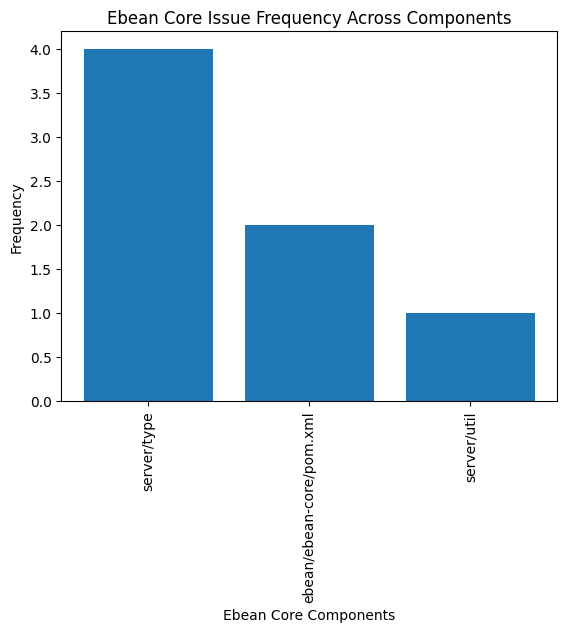

In [37]:
ebean_core_df = ebean_core_df.nlargest(15, 'subcomponent_frequency')
plt.bar(ebean_core_df['ebean_core_subcomponent'], ebean_core_df['subcomponent_frequency'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel('Ebean Core Components')
plt.ylabel('Frequency')
plt.title('Ebean Core Issue Frequency Across Components')
plt.show()

In [38]:
hibernate_core_pattern = r"hibernate-core/src/main/java/org/hibernate/(.*?)/(?=[A-Z])"
hibernate_core_df = pd.read_csv('coverity_data/coverity_hibernate-orm.csv')
hibernate_core_df = hibernate_core_df[hibernate_core_df['file_path'].str.contains('hibernate-core')]
hibernate_core_df['hibernate_core_subcomponent'] = hibernate_core_df['file_path'].apply(
    lambda x: extract_subcomponent(hibernate_core_pattern, x))
hibernate_core_df = hibernate_core_df.groupby(['hibernate_core_subcomponent']).size().reset_index(
    name='subcomponent_frequency')
hibernate_core_df.sort_values(by=['subcomponent_frequency'], ascending=False, inplace=True)
hibernate_core_df.reset_index(drop=True, inplace=True)
hibernate_core_df.head(96)

,hibernate_core_subcomponent,subcomponent_frequency
0,dialect,44
1,boot/model/internal,17
2,boot/jaxb/hbm/transform,9
3,sql/ast/spi,9
4,mapping,8
...,...,...
81,query/sqm/tree/select,1
82,resource/transaction/backend/jta/internal,1
83,service/internal,1
84,sql,1


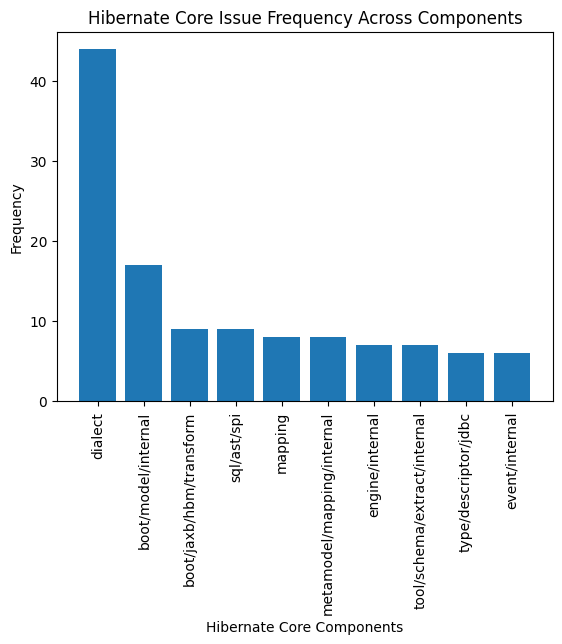

In [39]:
hibernate_core_df_top10 = hibernate_core_df.nlargest(10, 'subcomponent_frequency')
plt.bar(hibernate_core_df_top10['hibernate_core_subcomponent'], hibernate_core_df_top10['subcomponent_frequency'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel('Hibernate Core Components')
plt.ylabel('Frequency')
plt.title('Hibernate Core Issue Frequency Across Components')
plt.show()

In [40]:
openjpa_core_pattern = r"openjpa-kernel/src/main/java/org/apache/openjpa/(.*?)/(?=[A-Z])"
openjpa_core_df = pd.read_csv('coverity_data/coverity_openjpa.csv')
openjpa_core_df = openjpa_core_df[
    openjpa_core_df['file_path'].str.contains('openjpa-kernel') & ~openjpa_core_df['file_path'].str.contains('html') & ~
    openjpa_core_df['file_path'].str.contains('target')]
openjpa_core_df['openjpa_core_subcomponent'] = openjpa_core_df['file_path'].apply(
    lambda x: extract_subcomponent(openjpa_core_pattern, x))
openjpa_core_df = openjpa_core_df.groupby(['openjpa_core_subcomponent']).size().reset_index(
    name='subcomponent_frequency')
openjpa_core_df.sort_values(by=['subcomponent_frequency'], ascending=False, inplace=True)
openjpa_core_df.reset_index(drop=True, inplace=True)
openjpa_core_df.head(11)

,openjpa_core_subcomponent,subcomponent_frequency
0,kernel,58
1,enhance,12
2,kernel/jpql,12
3,meta,10
4,datacache,9
5,event,9
6,util,8
7,kernel/exps,6
8,conf,2
9,ee,1


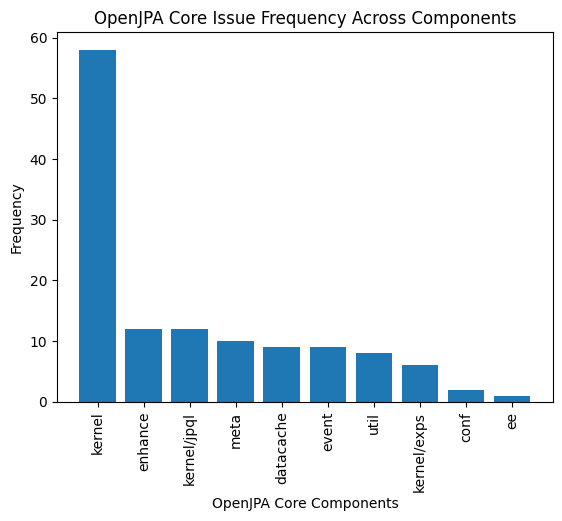

In [41]:
openjpa_core_df = openjpa_core_df.nlargest(10, 'subcomponent_frequency')
plt.bar(openjpa_core_df['openjpa_core_subcomponent'], openjpa_core_df['subcomponent_frequency'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel('OpenJPA Core Components')
plt.ylabel('Frequency')
plt.title('OpenJPA Core Issue Frequency Across Components')
plt.show()

In [42]:
extension_frequency = {}

for index, row in snyk_df.iterrows():
    # Extract the file extension
    extension = extract_extension(row['file_path'])
    # Increment the frequency count for the file extension
    extension_frequency[extension] = extension_frequency.get(extension, 0) + 1

# Create a DataFrame from the dictionary of extension frequencies
extension_df = pd.DataFrame(list(extension_frequency.items()), columns=['file_extension', 'frequency'])
extension_df.sort_values(by='frequency', inplace=True, ascending=False)
extension_df

,file_extension,frequency
1,java,121
0,xml,93
3,py,71
2,jsp,22
4,txt,4


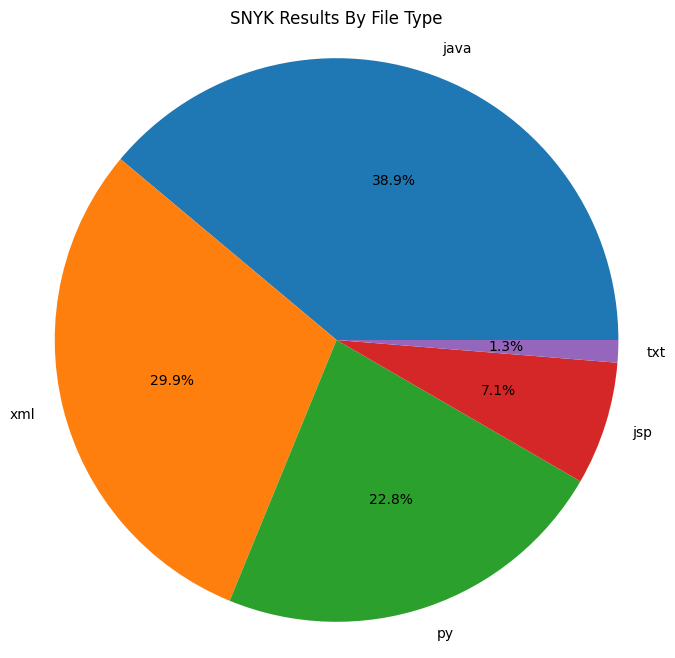

In [43]:
plt.figure(figsize=(8, 8))
plt.pie(extension_df['frequency'], labels=extension_df['file_extension'], autopct='%1.1f%%')
plt.title('SNYK Results By File Type')
plt.axis('equal')
plt.savefig('plots/snyk_results_file_type.pdf')
plt.show()

### SNYK Looks at xml, html, txt, jsp, build files, etc. Extensively

In [47]:
extensions = ['xml','html','jsp','txt']
pattern = '|'.join(extensions)
snyk_file_frequency_df = pd.read_csv('snyk_data/snyk_file_frequency.csv')
mask = snyk_file_frequency_df['file_path'].str.contains(pattern)
snyk_build_file_frequency_df = snyk_file_frequency_df[mask]
snyk_build_file_frequency_df.head(20)

,package,file_path,file_frequency
1,openjpa,openbooks/pom.xml,14
2,openjpa,openjpa-tools/openjpa-maven-plugin/pom.xml,12
3,openjpa,openjpa-examples/openbooks/web/query.jsp,12
5,openjpa,openjpa-examples/openbooks/web/search.jsp,8
7,openjpa,openjpa-kubernetes/pom.xml,8
9,ebean,ebean-postgis-types/pom.xml,6
10,openjpa,openjpa-jdbc/pom.xml,6
16,sqlalchemy,doc/build/requirements.txt,4
17,openjpa,openjpa-project/pom.xml,4
23,ebean,ebean-redis/pom.xml,4


In [46]:
extensions = ['.py','.java']
pattern = '|'.join(extensions)
snyk_file_frequency_df = pd.read_csv('snyk_data/snyk_file_frequency.csv')
mask = snyk_file_frequency_df['file_path'].str.contains(pattern)
snyk_nonbuild_file_frequency_df = snyk_file_frequency_df[mask]
snyk_nonbuild_file_frequency_df.head(10)

,package,file_path,file_frequency
0,sqlalchemy,test/orm/test_naturalpks.py,37
4,openjpa,openjpa-jest/src/main/java/org/apache/openjpa/...,10
6,hibernate,hibernate-core/src/test/java/org/hibernate/orm...,8
8,hibernate,hibernate-core/src/test/java/org/hibernate/orm...,7
11,openjpa,openjpa-jdbc/src/main/java/org/apache/openjpa/...,6
12,sqlalchemy,test/perf/many_table_reflection.py,5
13,hibernate,hibernate-testing/src/main/java/org/hibernate/...,5
14,hibernate,hibernate-testing/src/main/java/org/hibernate/...,5
15,ponyorm,pony/orm/tests/test_entity_init.py,5
18,hibernate,hibernate-community-dialects/src/test/java/org...,4
